In [1]:
using Distributed
using JLD
using LsqFit
using StatsBase
using Statistics
using Query
using Random
# @everywhere using Statistics
include("/nfshome/hshapourian/GaussianTNS/Code/RTN.jl")
using DataFrames
using PyPlot
@everywhere using Statistics

In [20]:
function hopp_vec(Mx,My,vec,px,py)
    # generates hoping matrix on square lattice
    # vec= hopping vector
    # py=1 PBC along y otherwise OBC
    # px=1 PBC along x otherwise OBC
    
    hopin=im*zeros(Mx*My,Mx*My)
    for i_y=0: (My-1)
        for i_x in 0: (Mx-1)
            i_px=i_x+vec[1]
            i_py=i_y+vec[2]
            if ((i_px>=Mx) || (i_px<0)) && (i_py< My) && (i_py>=0)
                if i_px>=Mx 
                    hx=px
                else
                    hx=conj(px)
                end
                i_px=i_px%Mx
                hopin[1+i_px+i_py*Mx,1+i_x+i_y*Mx]=hx
            elseif ((i_py>=My) || (i_py<0)) && (i_px< Mx) && (i_px>=0)
                if i_py>=My 
                    hy=py
                else
                    hy=conj(py)
                end
                i_py=i_py%My
#                 println(i_px," ",i_py)
                hopin[1+i_px+i_py*Mx,1+i_x+i_y*Mx]=hy
                    
            elseif ((i_px>=Mx) || (i_px<0)) && ((i_py>=My) || (i_py<0))
                if i_px>=Mx
                    hx=px
                else
                    hx=conj(px)
                end
                if i_py>=My
                    hy=py
                else
                    hy=conj(py)
                end
                i_px=mod(i_px,Mx)
                i_py=mod(i_py,My)
#                 print(i_px, " ")
                hopin[1+i_px+i_py*Mx,1+i_x+i_y*Mx]=hx*hy
                
            elseif (i_px>=0) && (i_px<Mx) && (i_py>=0) && (i_py<My) 
                hopin[1+i_px+i_py*Mx,1+i_x+i_y*Mx]=1
            end
        end
    end                   
    return hopin
end

function measure_onsite(psi,ind1,ind2,occ=0,amp_show=false)
    ## measurement circuit
    
    t_names = map(s -> Meta.parse(s), ["d", "u"])
    Te = BlockMatrix(t_names, [2,2])
    Te[t_names[1],t_names[1]] = [0.0 -1.0;1.0 0.0]
    Te[t_names[2],t_names[2]] = [0.0 1.0;-1.0 0.0]

    To = BlockMatrix(t_names, [2,2])
    To[t_names[1],t_names[1]] = [0.0 1.0;-1.0 0.0]
    To[t_names[2],t_names[2]] = [0.0 -1.0;1.0 0.0]

    T_contract = [Meta.parse("d")]
    
    fparity = 0 
    for k=ind1:ind2    
        psi_contract = [Meta.parse("idx$k")]
        if occ==0
            if amp_show
                psi, amp = schurContract_wPrefactor(psi, To, psi_contract, T_contract)
                println(amp)
            else
                psi = schurContract(psi, To, psi_contract, T_contract)
            end        
        elseif occ==1
            if amp_show
                psi, amp = schurContract_wPrefactor(psi, Te, psi_contract, T_contract)
                println(amp)
            else
                psi = schurContract(psi, Te, psi_contract, T_contract)
            end
        else
#             _ , amp = schurContract_wPrefactor(psi, Te, psi_contract, T_contract)
            amp = (1+psi[psi_contract,psi_contract][1,2])/2
#             println((amp-p2)>1e-7)
            if rand() < abs(amp)
                psi = schurContract(psi, Te, psi_contract, T_contract)
                fparity += 1
            else
                psi = schurContract(psi, To, psi_contract, T_contract)
            end    
        end
        rename!(psi, Meta.parse("u"), Meta.parse("idx$k"))
    end
    psi.M = (psi.M-psi.M')/2
    psi.M = purify(psi.M)
    return psi, fparity#(fparity%2)
end


measure_onsite (generic function with 3 methods)

In [18]:
t = 1
Δ = 1
Lx = 4
Ly = 16
N = 2*Lx*Ly
px= 1
py= -1

χ = 2 
i_names = map(i -> Meta.parse("idx$i"), 1:N)
i_sizes = fill(χ, N)
psi = BlockMatrix(i_names, i_sizes)

fparity = 0
l1 = Lx*div(Ly,2)
l2 = l1
dist = Lx*div(Ly,2)
# mlist = LinRange(1,3,12)
mlist = [1.0]

Nrep = 100
LN= zeros(length(mlist))
LN0= zeros(length(mlist))
LN1= zeros(length(mlist))
LN2= zeros(length(mlist),Nrep)
LN3= zeros(length(mlist),Nrep)
MI= zeros(length(mlist))
MI0= zeros(length(mlist))
MI1= zeros(length(mlist))
MI2= zeros(length(mlist),Nrep)
MI3= zeros(length(mlist),Nrep)

hx = hopp_vec(Lx,Ly,[1,0],px,py)
hy = hopp_vec(Lx,Ly,[0,1],px,py)
σx = [0 1;1 0]
σy = [0 -im;im 0]
σz = [1 0;0 -1]
Hhop = im*t*kron(hx-hx',σx)/2 + im*t*kron(hy-hy',σy)/2 - Δ*kron(hx+hx'+hy+hy',σz)/2

n_occ = zeros(Nrep)
for i_n=1:length(mlist)
    m = mlist[i_n]
    println(i_n)
    v1 = m* kron(ones(div(N,2)),[1,-1])
    H = Hhop + diagm(0=> v1)

    evals,evecs = eigen(H)
    Cmat = evecs[:,1:div(N,2)]  * evecs[:,1:div(N,2)]'
    CmatT = transpose(Cmat)
#     Gmat= kron(eye(N)- 2*Cmat,[0 1.0; 0 0])- kron(eye(N) -2*Cmat,[0 0; 1.0 0])
    Gmat = kron(I- Cmat-CmatT,[0 1.0;-1.0 0])+ im*kron(Cmat-CmatT,[1.0 0;0 1.0])

    psi[i_names,i_names] = real(Gmat)
    
    MI[i_n] = mutual_information(psi, i_names[1:l1], i_names[l1+dist+1:l1+l2+dist])
    LN[i_n] = logneg_of_sites(psi, i_names[1:l1], i_names[l1+dist+1:l1+l2+dist])

    s1=0
#     psi0 = measure(psi,s1+l1+1,s1+l1+dist,0)
#     LN0[i_n] = logneg_of_sites(psi0, i_names[s1+1:s1+l1], i_names[s1+l1+dist+1:s1+l1+l2+dist])
#     MI0[i_n] = mutual_information(psi0, i_names[s1+1:s1+l1], i_names[s1+l1+dist+1:s1+l1+l2+dist])

#     psi1 = measure(psi,s1+l1+1,s1+l1+dist,1)
#     LN1[i_n] = logneg_of_sites(psi1, i_names[s1+1:s1+l1], i_names[s1+l1+dist+1:s1+l1+l2+dist])
#     MI1[i_n] = mutual_information(psi1, i_names[s1+1:s1+l1], i_names[s1+l1+dist+1:s1+l1+l2+dist])

    for i_r= 1:Nrep
        psi3, f3 = measure_onsite(psi,s1+l1+1,s1+l1+dist,2)
#         while f3!=fparity
#             psi3, f3 = measure_onsite(psi,s1+l1+1,s1+l1+dist,2)
#         end
        n_occ[i_r]= f3
        LN3[i_n,i_r] = logneg_of_sites(psi3, i_names[s1+1:s1+l1], i_names[s1+l1+dist+1:s1+l1+l2+dist])
        MI3[i_n,i_r] = mutual_information(psi3, i_names[s1+1:s1+l1], i_names[s1+l1+dist+1:s1+l1+l2+dist])
        
#         psi2 = measure(psi,s1+l1+1,s1+l1+dist,2)
#         LN2[i_n,i_r] = logneg_of_sites(psi2, i_names[s1+1:s1+l1], i_names[s1+l1+dist+1:s1+l1+l2+dist])
#         MI2[i_n,i_r] = mutual_information(psi2, i_names[s1+1:s1+l1], i_names[s1+l1+dist+1:s1+l1+l2+dist])
    end
end

1


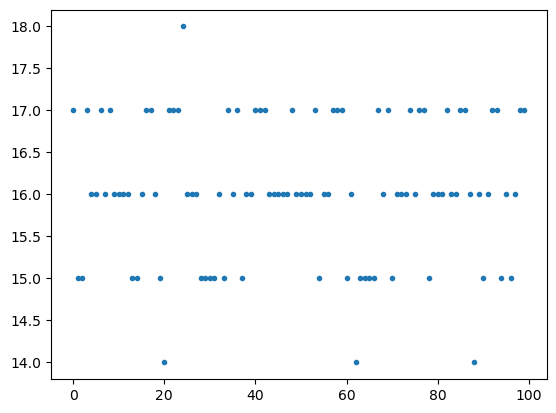

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2b488682cf70>

In [19]:
plot(n_occ,".")

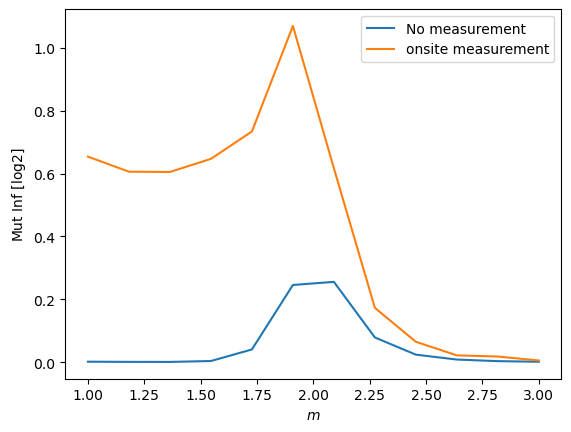

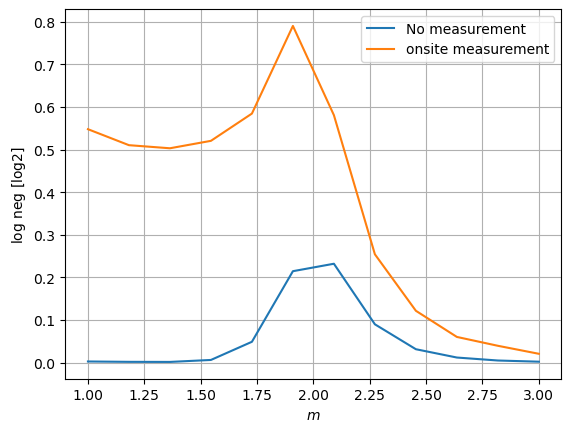

PyObject Text(0.5, 24.0, '$ m $')

In [123]:
plot(mlist,MI/log(2),label="No measurement")
# plot(mlist,mean(MI2,dims=2)/log(2),label="link measurement")
plot(mlist,mean(MI3,dims=2)/log(2),label="onsite measurement")

legend()
ylabel("Mut Inf \$ [\\log 2 ]\$")
xlabel("\$ m \$")

# plt.savefig("MI_vs_delta_64_32_32.pdf")
plt.show()

plt.figure()
plot(mlist,LN/log(2),label="No measurement")
# plot(mlist,mean(LN2,dims=2)/log(2),label="link measurement")
plot(mlist,mean(LN3,dims=2)/log(2),label="onsite measurement")
grid()

legend()
ylabel("log neg \$ [\\log 2 ]\$")
xlabel("\$ m \$")

# plt.savefig("SSH_LN_vs_delta_64_32_32.pdf")

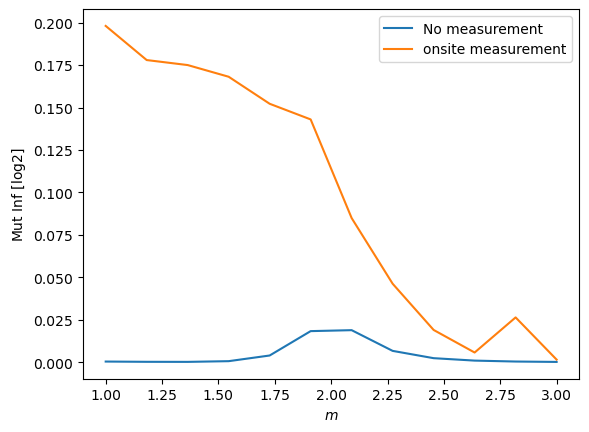

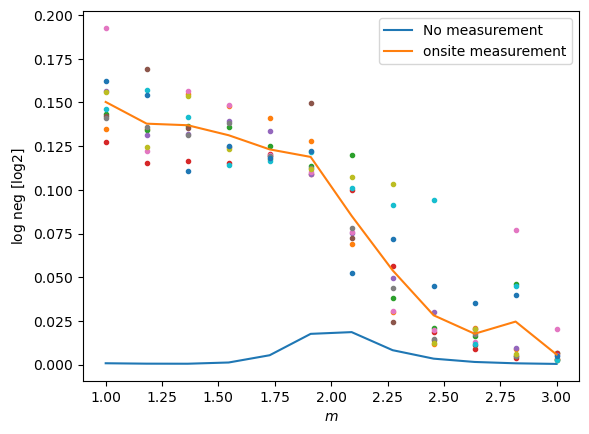

PyObject Text(0.5, 24.0, '$ m $')

In [129]:
plot(mlist,MI/log(2)/Lx,label="No measurement")
# plot(mlist,mean(MI2,dims=2)/log(2),label="link measurement")
plot(mlist,mean(MI3,dims=2)/log(2)/Lx,label="onsite measurement")

legend()
ylabel("Mut Inf \$ [\\log 2 ]\$")
xlabel("\$ m \$")

# plt.savefig("MI_vs_delta_64_32_32.pdf")
plt.show()

plt.figure()
plot(mlist,LN/log(2)/Lx,label="No measurement")
# plot(mlist,mean(LN2,dims=2)/log(2),label="link measurement")
plot(mlist,LN3/log(2)/Lx,".")
plot(mlist,mean(LN3,dims=2)/log(2)/Lx,label="onsite measurement")
# grid()

legend()
ylabel("log neg \$ [\\log 2 ]\$")
xlabel("\$ m \$")

# plt.savefig("SSH_LN_vs_delta_64_32_32.pdf")

# measuring charge in momentum space

In [119]:
t = 1
Δ = 1
Lx = 8
Ly = 32
N = 2*Ly
px= 1
py= -1

χ = 2 
i_names = map(i -> Meta.parse("idx$i"), 1:N)
i_sizes = fill(χ, N)
psi = BlockMatrix(i_names, i_sizes)

fparity = 0
l1 = div(N,4)
l2 = l1
dist = div(N,4)
mlist = LinRange(1,3,12)
# mlist = [1.0]

Nrep = 100
LN= zeros(length(mlist))
LN0= zeros(length(mlist))
LN1= zeros(length(mlist))
LN2= zeros(length(mlist),Nrep)
LN3= zeros(length(mlist),Nrep)
MI= zeros(length(mlist))
MI0= zeros(length(mlist))
MI1= zeros(length(mlist))
MI2= zeros(length(mlist),Nrep)
MI3= zeros(length(mlist),Nrep)

σx = [0 1;1 0]
σy = [0 -im;im 0]
σz = [1 0;0 -1]
hy = diagm( 1 => ones(div(N,2)-1) )
hy[div(N,2),1]=py
Hhop = im*t*kron(hy-hy',σy)/2 - Δ*kron(hy+hy',σz)/2

for i_n=1:length(mlist)
    m = mlist[i_n]
    println(i_n)

    for i_x = 1:Lx
        kx = 2*pi*(i_x-1)/Lx
        H = Hhop + kron(eye(div(N,2)), (m-Δ*cos(kx))*σz + t*sin(kx)*σx)

        evals,evecs = eigen(H)
#         figure(1)
#         plot(kx/(2*pi)*ones(N),evals,".")
        Cmat = evecs[:,1:div(N,2)]  * evecs[:,1:div(N,2)]'
        CmatT = transpose(Cmat)
        Gmat = kron(I- Cmat-CmatT,[0 1.0;-1.0 0])+ im*kron(Cmat-CmatT,[1.0 0;0 1.0])
        psi[i_names,i_names] = real(Gmat)

        MI[i_n] += mutual_information(psi, i_names[1:l1], i_names[l1+dist+1:l1+l2+dist])
        LN[i_n] += logneg_of_sites(psi, i_names[1:l1], i_names[l1+dist+1:l1+l2+dist])

        for i_r= 1:Nrep
            psi3, f3 = measure_onsite(psi,l1+1,l1+dist,2)
#             while f3!=fparity
#                 psi3, f3 = measure_onsite(psi,l1+1,l1+dist,2)
#             end
            LN3[i_n,i_r] += logneg_of_sites(psi3, i_names[1:l1], i_names[l1+dist+1:l1+l2+dist])
            MI3[i_n,i_r] += mutual_information(psi3, i_names[1:l1], i_names[l1+dist+1:l1+l2+dist])

        end
    end
end

1
2
3
4
5
6
7
8
9
10
11
12


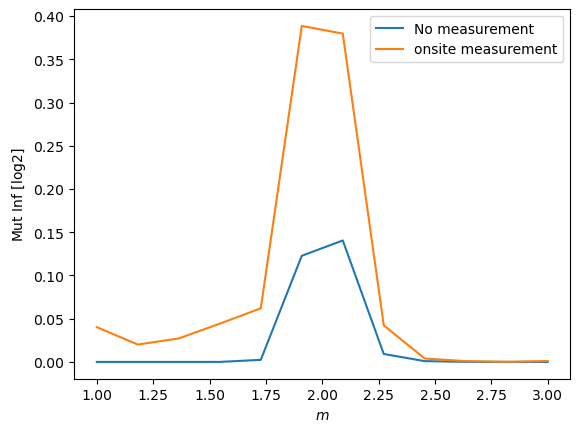

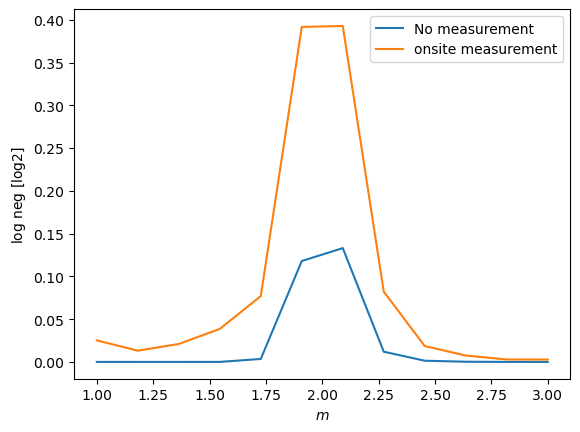

PyObject Text(0.5, 24.0, '$ m $')

In [120]:
plot(mlist,MI/log(2),label="No measurement")
# plot(mlist,mean(MI2,dims=2)/log(2),label="link measurement")
plot(mlist,mean(MI3,dims=2)/log(2),label="onsite measurement")

legend()
ylabel("Mut Inf \$ [\\log 2 ]\$")
xlabel("\$ m \$")

# plt.savefig("MI_vs_delta_64_32_32.pdf")
plt.show()

plt.figure()
plot(mlist,LN/log(2),label="No measurement")
# plot(mlist,mean(LN2,dims=2)/log(2),label="link measurement")
plot(mlist,mean(LN3,dims=2)/log(2),label="onsite measurement")
# grid()

legend()
ylabel("log neg \$ [\\log 2 ]\$")
xlabel("\$ m \$")

# plt.savefig("SSH_LN_vs_delta_64_32_32.pdf")